## Get states for each work trajectory for A42T

In [1]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm
import argparse
import random
from simtk.openmm.app import Modeller


In [64]:
# Get dihedrals
def get_dihedrals(i, phase, direction, outdir, htf, dihedral_indices_new, dihedral_indices_old):
    # Get topology with solute only
    modeller = Modeller(htf._topology_proposal.new_topology, htf.new_positions(htf.hybrid_positions))
#     modeller.deleteWater()
    new_top = md.Topology.from_openmm(modeller.topology)
    
    # Get last positions from eq positions of each cycle (positions are solute only)
    from tqdm import tqdm
    all_pos_new = []
    for j in tqdm(range(100)):
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_{direction}_neq_new.npy"), "rb") as f:
                all_pos_new.append(np.load(f)[0])
        except FileNotFoundError:
            pass
    print(f"new files found: {len(all_pos_new)}")
    
    # Compute dihedrals
    traj = md.Trajectory(np.array(all_pos_new), new_top)
    dihedrals_new = md.compute_dihedrals(traj, np.array([dihedral_indices_new]))
    
    return dihedrals_new

#### Get dihedrals for apo

In [65]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/13/1/"
phase = "apo"
i = os.path.basename(os.path.dirname(outdir))


In [66]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [67]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 681]
dihedrals_new_apo = get_dihedrals(i, phase, 'reverse', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:07<00:00, 12.91it/s]

new files found: 100


#### Get dihedrals for complex

In [68]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/13/1/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir))


In [69]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [70]:
indices_old = [669, 670, 673, 676]
indices_new = [669, 670, 673, 681]
dihedrals_new_complex = get_dihedrals(i, phase, 'reverse', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:11<00:00,  8.45it/s]


new files found: 100


In [71]:
# Define indicator function
def get_state(dihedral_angle):
    if dihedral_angle > 2 or dihedral_angle < -2: # angle is -3 or +3
        return 0
    elif dihedral_angle < 0 and dihedral_angle > -2: # angle is -1
        return 1
    elif dihedral_angle > 0 and dihedral_angle < 2: # angle is 1
        return 2

In [72]:
# Create list of states for each work traj
states_apo = [get_state(angle) for angle in dihedrals_new_apo]
states_complex = [get_state(angle) for angle in dihedrals_new_complex]

In [29]:
for i in range(100):
    if i < 33:
        print(states_complex[i])

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [31]:
for i in range(100):
    if i >= 33 and i < 66:
        print(states_complex[i])

2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [30]:
for i in range(100):
    if i >= 66:
        print(states_complex[i])

1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


## Run estimator on A42T

In [73]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd

In [74]:
def analyze_minh(input_works):
    """
    symmetric protocol free energy that gavin got from plugging in symmetric protocols into bidirectional estimator
    
    arguments
        input_works : np.array(N, 2)
            input_works[:,0] is work  accumulated from start to midpoint
            input_works[:,1] is work accumulated from midpoint to end
    
    returns
        free_energy : float
            reduced free energy
    """
    N = input_works.shape[0]
    w_abs, w_bcs = input_works[:,0], input_works[:,1]
    w_ab_max, w_bc_max = np.max(w_abs), np.max(w_bcs)
    
    denominators = np.exp(w_abs - w_ab_max) + np.exp(-w_bcs - w_ab_max)
    
    return -np.log(2./N) - np.log(np.sum(1./denominators)) + w_ab_max

In [75]:
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [76]:
# Prep work arrays (from distributed jobs) and call analyze()
# titles = ["T42A", "A42T", "Y29A", "A29Y", "W38F", "F38W", "W44F", "F44W", "Y29F", "F29Y"]
titles = ["A42T"]
d_results = {}
d_phases = {}
first = 1
for i in tqdm_notebook([1]):
    print(f"dir: {i}")
    # Load and combine arrays
    forward_complex_arrays = []
    reverse_complex_arrays = []
    forward_apo_arrays = []
    reverse_apo_arrays = []
    for j in range(100):
        print(f"job: {j}")
        forward_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_complex_{j}_forward.npy'
        reverse_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_complex_{j}_reverse.npy'
        forward_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_apo_{j}_forward.npy'
        reverse_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_apo_{j}_reverse.npy'
        if os.path.exists(forward_complex_path):
            with open(forward_complex_path, 'rb') as f:
                array = np.load(f)
                forward_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_complex_path):
            with open(reverse_complex_path, 'rb') as f:
                array = np.load(f)
                reverse_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(forward_apo_path):
            with open(forward_apo_path, 'rb') as f:
                array = np.load(f)
                forward_apo_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_apo_path):
            with open(reverse_apo_path, 'rb') as f:
                array = np.load(f)
                print(array.shape)
                reverse_apo_arrays.append(array)


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


dir: 1
job: 0
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 1
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 2
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 3
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 4
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 5
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 6
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 7
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 8
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 9
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 10
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 11
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 12
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 13
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 14
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 15
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 16
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 17
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

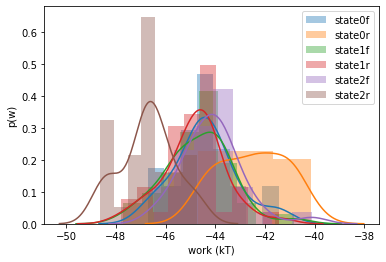

In [77]:
if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:
    
    # Get forward and reverse accumulated works
    forward_complex_combined = np.concatenate(forward_complex_arrays)
    forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
    
    reverse_complex_combined = np.concatenate(reverse_complex_arrays)
    reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
        
    forward_apo_combined = np.concatenate(forward_apo_arrays)
    forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])

    reverse_apo_combined = np.concatenate(reverse_apo_arrays)
    reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])

    # Prep input for estimator
    d_input_works = {}
    d_input_works['apo'] = {}
    d_input_works['complex'] = {}
    d_input_works['apo'][0], d_input_works['apo'][1], d_input_works['apo'][2] = list(), list(), list()
    d_input_works['complex'][0], d_input_works['complex'][1], d_input_works['complex'][2] = list(), list(), list()
    n_cycles_apo = len(forward_apo_arrays)
    for i in range(n_cycles_apo):
        state = states_apo[i]
        d_input_works['apo'][state].append([forward_apo_accumulated[i], reverse_apo_accumulated[i]])
        
    n_cycles_complex = len(forward_complex_arrays)
    for i in range(n_cycles_complex):
        state = states_complex[i]
        d_input_works['complex'][state].append([forward_complex_accumulated[i], reverse_complex_accumulated[i]])

        
    # Plot work distributions
    for i in range(3):
        sns.distplot(np.array(d_input_works['apo'][i])[:,0], label=f"state{i}f")
        sns.distplot(np.array(d_input_works['apo'][i])[:,1]*-1, label=f"state{i}r")
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.legend()
    plt.show()
#     plt.title(f"{title} {phase}")
#     plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
#     print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
#     plt.clf()    
else:
    print(f"dir {i} has at least one phase without data" )

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

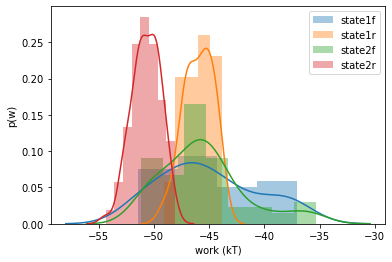

In [78]:
# Plot work distributions
plt.clf()
for i in [1,2]:
    sns.distplot(np.array(d_input_works['complex'][i])[:,0], label=f"state{i}f")
    sns.distplot(np.array(d_input_works['complex'][i])[:,1]*-1, label=f"state{i}r")
plt.xlabel("work (kT)")
plt.ylabel("p(w)")
plt.legend()
plt.show()

#### apo

100%|██████████| 10000/10000 [00:44<00:00, 222.96it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

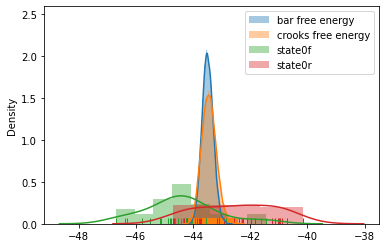

In [79]:
import tqdm
all_free_energies = []
for state in [0]:
    N_bootstraps = 10000
    free_energies = []
    free_energies_minh = []
    work_array = np.array(d_input_works['apo'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        dg, ddg = pymbar.bar.BAR(work_array[subsample_indices][:,0], work_array[subsample_indices][:,1])
        free_energies.append(dg)
        free_energies_minh.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"bar free energy", rug=True)
    sns.distplot(np.array(free_energies_minh), label=f"crooks free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:34<00:00, 293.42it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

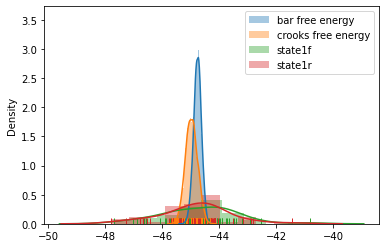

In [80]:
import tqdm
for state in [1]:
    N_bootstraps = 10000
    free_energies = []
    free_energies_minh = []
    work_array = np.array(d_input_works['apo'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        dg, ddg = pymbar.bar.BAR(work_array[subsample_indices][:,0], work_array[subsample_indices][:,1])
        free_energies.append(dg)
        free_energies_minh.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"bar free energy", rug=True)
    sns.distplot(np.array(free_energies_minh), label=f"crooks free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:29<00:00, 343.52it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

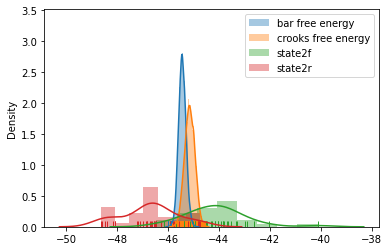

In [81]:
import tqdm
# all_free_energies = []
for state in [2]:
    N_bootstraps = 10000
    free_energies = []
    free_energies_minh = []
    work_array = np.array(d_input_works['apo'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        dg, ddg = pymbar.bar.BAR(work_array[subsample_indices][:,0], work_array[subsample_indices][:,1])
        free_energies.append(dg)
        free_energies_minh.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"bar free energy", rug=True)
    sns.distplot(np.array(free_energies_minh), label=f"crooks free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

now, all_free_energies has two sub lists, one for the bootstrapped free energies of state 1, another for state 2

In [82]:
def combine(state_0, state_1, state_2):
    return -np.log(np.exp(-state_0) + np.exp(-state_1) + np.exp(-state_2))

In [83]:
combined_free_energies = []
for i in tqdm.trange(N_bootstraps):
    combined_free_energies.append(combine(all_free_energies[0][i], all_free_energies[1][i], all_free_energies[2][i]))

100%|██████████| 10000/10000 [00:00<00:00, 54869.96it/s]


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

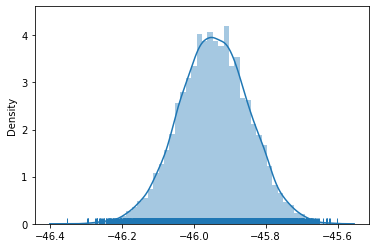

In [84]:
sns.distplot(combined_free_energies, rug=True)

In [85]:
np.mean(combined_free_energies)*KT_KCALMOL

-27.39023261100211

In [86]:
np.std(combined_free_energies)*KT_KCALMOL

0.058430921750920635

In [87]:
np.percentile(combined_free_energies, 2.5)*KT_KCALMOL, np.percentile(combined_free_energies, 97.5)*KT_KCALMOL

(-27.507105574505346, -27.2774631621508)

#### complex

In [47]:
# import tqdm
# all_free_energies = []
# for state in [0]:
#     N_bootstraps = 10000
#     free_energies = []
#     free_energies_minh = []
#     work_array = np.array(d_input_works['complex'][state])
#     num_samples = work_array.shape[0]
#     for i in tqdm.trange(N_bootstraps):
#         subsample_indices = np.random.choice(range(num_samples), num_samples)
#         dg, ddg = pymbar.bar.BAR(work_array[subsample_indices][:,0], work_array[subsample_indices][:,1])
#         free_energies.append(dg)
#         free_energies_minh.append(analyze_minh(work_array[subsample_indices]))
#     sns.distplot(np.array(free_energies), label=f"bar free energy", rug=True)
#     sns.distplot(np.array(free_energies_minh), label=f"crooks free energy", rug=True)
#     sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
#     sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
#     all_free_energies.append(free_energies)
# plt.legend()
# plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]


IndexError: arrays used as indices must be of integer (or boolean) type

100%|██████████| 10000/10000 [00:40<00:00, 246.02it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

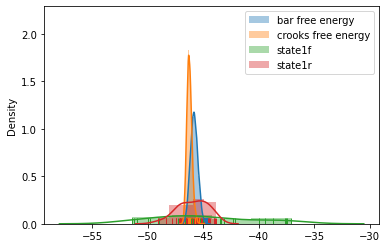

In [89]:
import tqdm
all_free_energies = []
for state in [1]:
    N_bootstraps = 10000
    free_energies = []
    free_energies_minh = []
    work_array = np.array(d_input_works['complex'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        dg, ddg = pymbar.bar.BAR(work_array[subsample_indices][:,0], work_array[subsample_indices][:,1])
        free_energies.append(dg)
        free_energies_minh.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"bar free energy", rug=True)
    sns.distplot(np.array(free_energies_minh), label=f"crooks free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:42<00:00, 235.49it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

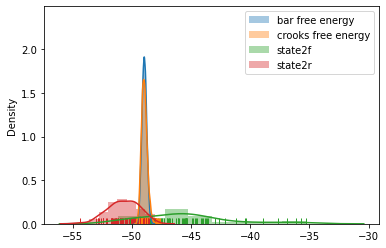

In [90]:
import tqdm
# all_free_energies = []
for state in [2]:
    N_bootstraps = 10000
    free_energies = []
    free_energies_minh = []
    work_array = np.array(d_input_works['complex'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        dg, ddg = pymbar.bar.BAR(work_array[subsample_indices][:,0], work_array[subsample_indices][:,1])
        free_energies.append(dg)
        free_energies_minh.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"bar free energy", rug=True)
    sns.distplot(np.array(free_energies_minh), label=f"crooks free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

now, all_free_energies has three sub lists

In [91]:
def combine(state_1, state_2):
    return -np.log(np.exp(-state_1) + np.exp(-state_2))

In [93]:
combined_free_energies_complex = []
for i in tqdm.trange(N_bootstraps):
    combined_free_energies_complex.append(combine(all_free_energies[0][i], all_free_energies[1][i]))

100%|██████████| 10000/10000 [00:00<00:00, 77652.60it/s]


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

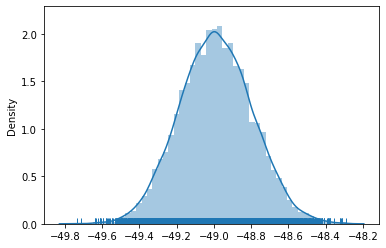

In [94]:
sns.distplot(combined_free_energies_complex, rug=True)

In [95]:
np.mean(combined_free_energies_complex)*KT_KCALMOL

-29.205462711246756

In [96]:
np.std(combined_free_energies_complex)*KT_KCALMOL

0.11694252157092637

In [97]:
np.percentile(combined_free_energies_complex, 2.5)*KT_KCALMOL, np.percentile(combined_free_energies_complex, 97.5)*KT_KCALMOL

(-29.43165503243647, -28.97576684370111)

In [98]:
# bootstrap the combined_free energies
ddg = [combined_free_energies_complex[i] - combined_free_energies[i] for i in range(N_bootstraps)]

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

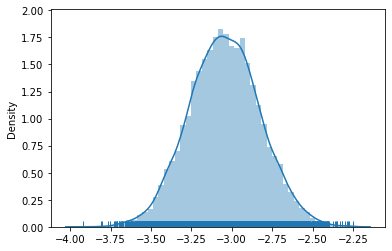

In [99]:
sns.distplot(ddg, rug=True)

In [100]:
np.mean(ddg)*KT_KCALMOL

-1.815230100244652

In [101]:
np.std(ddg)*KT_KCALMOL

0.1312350633055154

## Get states for each work trajectory for T42A 

In [102]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from tqdm import tqdm
import argparse
import random
from simtk.openmm.app import Modeller


In [103]:
# Get dihedrals
def get_dihedrals(i, phase, direction, outdir, htf, dihedral_indices_new, dihedral_indices_old):
    # Get topology with solute only
    modeller = Modeller(htf._topology_proposal.old_topology, htf.old_positions(htf.hybrid_positions))
#     modeller.deleteWater()
    old_top = md.Topology.from_openmm(modeller.topology)
    
    # Get last positions from eq positions of each cycle (positions are solute only)
    from tqdm import tqdm
    all_pos_old = []
    for j in tqdm(range(100)):
        try:
            with open(os.path.join(outdir, f"{i}_{phase}_{j}_{direction}_neq_old.npy"), "rb") as f:
                all_pos_old.append(np.load(f)[0])
        except FileNotFoundError:
            pass
    print(f"new files found: {len(all_pos_old)}")
    
    # Compute dihedrals
    traj = md.Trajectory(np.array(all_pos_old), old_top)
    dihedrals_old = md.compute_dihedrals(traj, np.array([dihedral_indices_old]))
    
    return dihedrals_old

#### Get dihedrals for apo

In [104]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/13/0/"
phase = "apo"
i = os.path.basename(os.path.dirname(outdir))


In [105]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [106]:
indices_old = [669, 670, 673, 674]
indices_new = [669, 670, 673, 676]
dihedrals_new_apo = get_dihedrals(i, phase, 'forward', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:05<00:00, 19.66it/s]

new files found: 100


In [149]:
with open(os.path.join("/data/chodera/zhangi/perses_benchmark/neq/13/0/", f"{0}_{'apo'}_{0}.npy"), "rb") as f:
    pos_apo = np.load(f)

In [152]:
pos_apo_old = []
for pos in pos_apo:
    pos_apo_old.append(htf.old_positions(pos*unit.nanometer))

IndexError: index 14881 is out of bounds for axis 0 with size 14881

In [150]:
modeller = Modeller(htf._topology_proposal.old_topology, htf.old_positions(htf.hybrid_positions))
#     modeller.deleteWater()
old_top = md.Topology.from_openmm(modeller.topology)

# Compute dihedrals
indices_old = [669, 670, 673, 674]
traj = md.Trajectory(htf.old_positions(pos_apo), old_top)
dihedrals_old = md.compute_dihedrals(traj, np.array([indices_old]))

AttributeError: 'numpy.ndarray' object has no attribute 'unit'

#### Get dihedrals for complex

In [107]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/13/0/"
phase = "complex"
i = os.path.basename(os.path.dirname(outdir))


In [108]:
with open(os.path.join(outdir, f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [109]:
indices_old = [669, 670, 673, 674]
indices_new = [669, 670, 673, 676]
dihedrals_new_complex = get_dihedrals(i, phase, 'forward', outdir, htf, indices_new, indices_old)                                       


100%|██████████| 100/100 [00:08<00:00, 12.41it/s]


new files found: 100


In [110]:
# Define indicator function
def get_state(dihedral_angle):
    if dihedral_angle > 2 or dihedral_angle < -2: # angle is -3 or +3
        return 0
    elif dihedral_angle < 0 and dihedral_angle > -2: # angle is -1
        return 1
    elif dihedral_angle > 0 and dihedral_angle < 2: # angle is 1
        return 2

In [111]:
# Create list of states for each work traj
states_apo = [get_state(angle) for angle in dihedrals_new_apo]
states_complex = [get_state(angle) for angle in dihedrals_new_complex]

In [115]:
for i in range(100):
    if i < 33:
        print(states_complex[i])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [116]:
for i in range(100):
    if i >= 33 and i < 66:
        print(states_complex[i])

0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [117]:
for i in range(100):
    if i >= 66:
        print(states_complex[i])

1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


## Run estimator on T42A

In [118]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd

In [119]:
def analyze_minh(input_works):
    """
    symmetric protocol free energy that gavin got from plugging in symmetric protocols into bidirectional estimator
    
    arguments
        input_works : np.array(N, 2)
            input_works[:,0] is work  accumulated from start to midpoint
            input_works[:,1] is work accumulated from midpoint to end
    
    returns
        free_energy : float
            reduced free energy
    """
    N = input_works.shape[0]
    w_abs, w_bcs = input_works[:,0], input_works[:,1]
    w_ab_max, w_bc_max = np.max(w_abs), np.max(w_bcs)
    
    denominators = np.exp(w_abs - w_ab_max) + np.exp(-w_bcs - w_ab_max)
    
    return -np.log(2./N) - np.log(np.sum(1./denominators)) + w_ab_max

In [120]:
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [121]:
# Prep work arrays (from distributed jobs) and call analyze()
# titles = ["T42A", "A42T", "Y29A", "A29Y", "W38F", "F38W", "W44F", "F44W", "Y29F", "F29Y"]
titles = ["T42A"]
d_results = {}
d_phases = {}
first = 0
for i in tqdm_notebook([0]):
    print(f"dir: {i}")
    # Load and combine arrays
    forward_complex_arrays = []
    reverse_complex_arrays = []
    forward_apo_arrays = []
    reverse_apo_arrays = []
    for j in range(100):
        print(f"job: {j}")
        forward_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_complex_{j}_forward.npy'
        reverse_complex_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_complex_{j}_reverse.npy'
        forward_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_apo_{j}_forward.npy'
        reverse_apo_path = f'/data/chodera/zhangi/perses_benchmark/neq/13/{i}/{i}_apo_{j}_reverse.npy'
        if os.path.exists(forward_complex_path):
            with open(forward_complex_path, 'rb') as f:
                array = np.load(f)
                forward_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_complex_path):
            with open(reverse_complex_path, 'rb') as f:
                array = np.load(f)
                reverse_complex_arrays.append(array)
                print(array.shape)
        if os.path.exists(forward_apo_path):
            with open(forward_apo_path, 'rb') as f:
                array = np.load(f)
                forward_apo_arrays.append(array)
                print(array.shape)
        if os.path.exists(reverse_apo_path):
            with open(reverse_apo_path, 'rb') as f:
                array = np.load(f)
                print(array.shape)
                reverse_apo_arrays.append(array)


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


dir: 0
job: 0
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 1
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 2
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 3
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 4
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 5
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 6
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 7
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 8
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 9
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 10
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 11
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 12
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 13
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 14
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 15
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 16
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250001)
job: 17
(1, 250001)
(1, 250001)
(1, 250001)
(1, 250

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

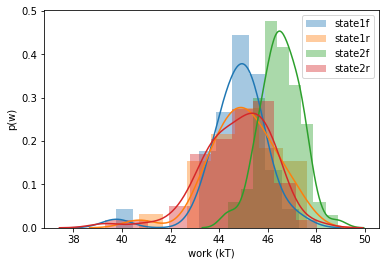

In [124]:
if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:
    
    # Get forward and reverse accumulated works
    forward_complex_combined = np.concatenate(forward_complex_arrays)
    forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
    
    reverse_complex_combined = np.concatenate(reverse_complex_arrays)
    reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
        
    forward_apo_combined = np.concatenate(forward_apo_arrays)
    forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])

    reverse_apo_combined = np.concatenate(reverse_apo_arrays)
    reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])

    # Prep input for estimator
    d_input_works = {}
    d_input_works['apo'] = {}
    d_input_works['complex'] = {}
    d_input_works['apo'][0], d_input_works['apo'][1], d_input_works['apo'][2] = list(), list(), list()
    d_input_works['complex'][0], d_input_works['complex'][1], d_input_works['complex'][2] = list(), list(), list()
    n_cycles_apo = len(forward_apo_arrays)
    for i in range(n_cycles_apo):
        state = states_apo[i]
        d_input_works['apo'][state].append([forward_apo_accumulated[i], reverse_apo_accumulated[i]])
        
    n_cycles_complex = len(forward_complex_arrays)
    for i in range(n_cycles_complex):
        state = states_complex[i]
        d_input_works['complex'][state].append([forward_complex_accumulated[i], reverse_complex_accumulated[i]])

        
    # Plot work distributions
#     colors = [['blue', 'cyan'], ['red', 'orange'], ['green', 'forestgreen'] ]
    for i in [1,2]:
        sns.distplot(np.array(d_input_works['apo'][i])[:,0], label=f"state{i}f")
        sns.distplot(np.array(d_input_works['apo'][i])[:,1]*-1, label=f"state{i}r")
#     plt.axvline(dg)
#     plt.axvline(dg + ddg, linestyle='dashed')
#     plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.legend()
    plt.show()
#     plt.title(f"{title} {phase}")
#     plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
#     print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
#     plt.clf()    
else:
    print(f"dir {i} has at least one phase without data" )

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code

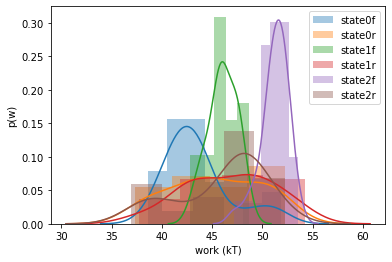

In [126]:
# Plot work distributions
plt.clf()
for i in [0, 1,2]:
    sns.distplot(np.array(d_input_works['complex'][i])[:,0], label=f"state{i}f")
    sns.distplot(np.array(d_input_works['complex'][i])[:,1]*-1, label=f"state{i}r")
plt.xlabel("work (kT)")
plt.ylabel("p(w)")
plt.legend()
plt.show()

#### apo

100%|██████████| 10000/10000 [00:43<00:00, 229.42it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

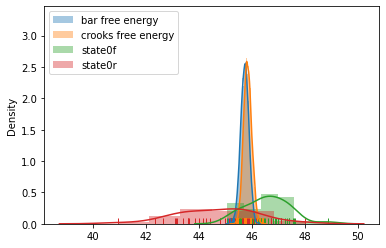

In [52]:
# import tqdm
# all_free_energies = []
# for state in [0]:
#     N_bootstraps = 10000
#     free_energies = []
#     free_energies_minh = []
#     work_array = np.array(d_input_works['apo'][state])
#     num_samples = work_array.shape[0]
#     for i in tqdm.trange(N_bootstraps):
#         subsample_indices = np.random.choice(range(num_samples), num_samples)
#         dg, ddg = pymbar.bar.BAR(work_array[subsample_indices][:,0], work_array[subsample_indices][:,1])
#         free_energies.append(dg)
#         free_energies_minh.append(analyze_minh(work_array[subsample_indices]))
#     sns.distplot(np.array(free_energies), label=f"bar free energy", rug=True)
#     sns.distplot(np.array(free_energies_minh), label=f"crooks free energy", rug=True)
#     sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
#     sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
#     all_free_energies.append(free_energies)
# plt.legend()
# plt.show()

100%|██████████| 10000/10000 [00:34<00:00, 291.47it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

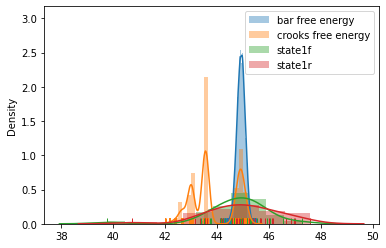

In [127]:
import tqdm
all_free_energies = []
for state in [1]:
    N_bootstraps = 10000
    free_energies = []
    free_energies_minh = []
    work_array = np.array(d_input_works['apo'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        dg, ddg = pymbar.bar.BAR(work_array[subsample_indices][:,0], work_array[subsample_indices][:,1])
        free_energies.append(dg)
        free_energies_minh.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"bar free energy", rug=True)
    sns.distplot(np.array(free_energies_minh), label=f"crooks free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:31<00:00, 320.59it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

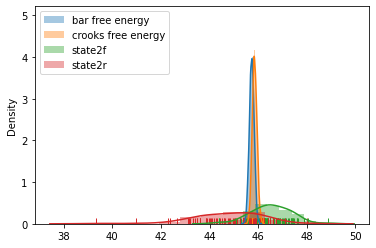

In [128]:
import tqdm
# all_free_energies = []
for state in [2]:
    N_bootstraps = 10000
    free_energies = []
    free_energies_minh = []
    work_array = np.array(d_input_works['apo'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        dg, ddg = pymbar.bar.BAR(work_array[subsample_indices][:,0], work_array[subsample_indices][:,1])
        free_energies.append(dg)
        free_energies_minh.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"bar free energy", rug=True)
    sns.distplot(np.array(free_energies_minh), label=f"crooks free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

now, all_free_energies has two sub lists, one for the bootstrapped free energies of state 1, another for state 2

In [129]:
def combine(state_1, state_2):
    return -np.log(np.exp(-state_1) + np.exp(-state_2))

In [130]:
combined_free_energies = []
for i in tqdm.trange(N_bootstraps):
    combined_free_energies.append(combine(all_free_energies[0][i], all_free_energies[1][i]))

100%|██████████| 10000/10000 [00:00<00:00, 79724.61it/s]


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

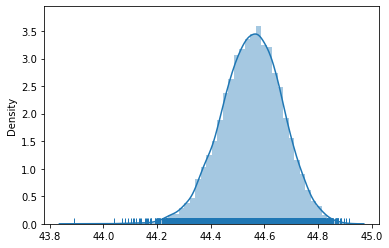

In [131]:
sns.distplot(combined_free_energies, rug=True)

In [132]:
np.mean(combined_free_energies)*KT_KCALMOL

26.56046322626732

In [133]:
np.std(combined_free_energies)*KT_KCALMOL

0.06825058842971139

In [134]:
np.percentile(combined_free_energies, 2.5)*KT_KCALMOL, np.percentile(combined_free_energies, 97.5)*KT_KCALMOL

(26.420527183493064, 26.68772119856155)

#### complex

100%|██████████| 10000/10000 [01:03<00:00, 157.87it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

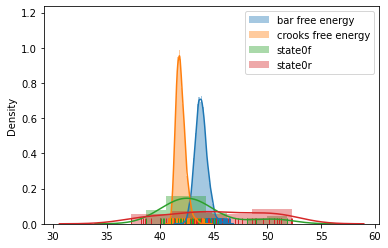

In [135]:
import tqdm
all_free_energies = []
for state in [0]:
    N_bootstraps = 10000
    free_energies = []
    free_energies_minh = []
    work_array = np.array(d_input_works['complex'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        dg, ddg = pymbar.bar.BAR(work_array[subsample_indices][:,0], work_array[subsample_indices][:,1])
        free_energies.append(dg)
        free_energies_minh.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"bar free energy", rug=True)
    sns.distplot(np.array(free_energies_minh), label=f"crooks free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:49<00:00, 202.15it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

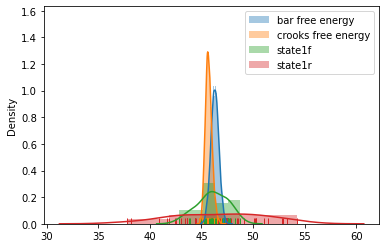

In [136]:
import tqdm
for state in [1]:
    N_bootstraps = 10000
    free_energies = []
    free_energies_minh = []
    work_array = np.array(d_input_works['complex'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        dg, ddg = pymbar.bar.BAR(work_array[subsample_indices][:,0], work_array[subsample_indices][:,1])
        free_energies.append(dg)
        free_energies_minh.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"bar free energy", rug=True)
    sns.distplot(np.array(free_energies_minh), label=f"crooks free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:36<00:00, 273.61it/s]
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

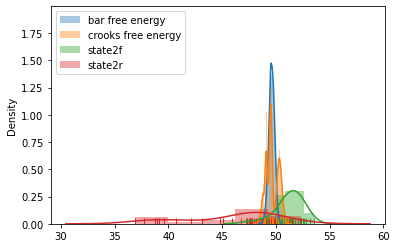

In [137]:
import tqdm
# all_free_energies = []
for state in [2]:
    N_bootstraps = 10000
    free_energies = []
    free_energies_minh = []
    work_array = np.array(d_input_works['complex'][state])
    num_samples = work_array.shape[0]
    for i in tqdm.trange(N_bootstraps):
        subsample_indices = np.random.choice(range(num_samples), num_samples)
        dg, ddg = pymbar.bar.BAR(work_array[subsample_indices][:,0], work_array[subsample_indices][:,1])
        free_energies.append(dg)
        free_energies_minh.append(analyze_minh(work_array[subsample_indices]))
    sns.distplot(np.array(free_energies), label=f"bar free energy", rug=True)
    sns.distplot(np.array(free_energies_minh), label=f"crooks free energy", rug=True)
    sns.distplot(work_array[:,0], label=f"state{state}f", rug=True)
    sns.distplot(work_array[:,1]*-1, label=f"state{state}r", rug=True)
    all_free_energies.append(free_energies)
plt.legend()
plt.show()

now, all_free_energies has three sub lists

In [138]:
def combine(state_0, state_1, state_2):
    return -np.log(np.exp(-state_0) + np.exp(-state_1) + np.exp(-state_2))

In [139]:
combined_free_energies_complex = []
for i in tqdm.trange(N_bootstraps):
    combined_free_energies_complex.append(combine(all_free_energies[0][i], all_free_energies[1][i], all_free_energies[2][i]))

100%|██████████| 10000/10000 [00:00<00:00, 56990.07it/s]


/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

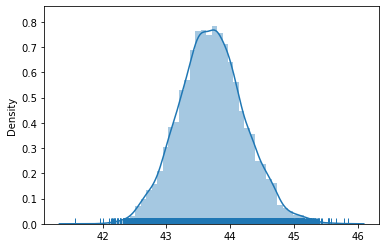

In [140]:
sns.distplot(combined_free_energies_complex, rug=True)

In [141]:
np.mean(combined_free_energies_complex)*KT_KCALMOL

26.059658035515135

In [142]:
np.std(combined_free_energies_complex)*KT_KCALMOL

0.31068371324442284

In [143]:
np.percentile(combined_free_energies_complex, 2.5)*KT_KCALMOL, np.percentile(combined_free_energies_complex, 97.5)*KT_KCALMOL

(25.46113492149686, 26.6829357738323)

In [144]:
# bootstrap the combined_free energies
ddg = [combined_free_energies_complex[i] - combined_free_energies[i] for i in range(N_bootstraps)]

/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhangi/miniconda3/envs/perses-sims-oct2020/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

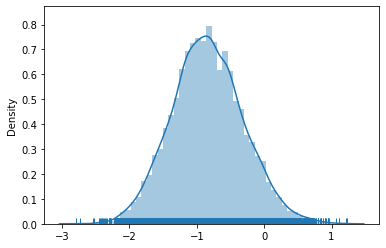

In [145]:
sns.distplot(ddg, rug=True)

In [146]:
np.mean(ddg)*KT_KCALMOL

-0.5008051907521831

In [147]:
np.std(ddg)*KT_KCALMOL

0.3176700263836714

In [ ]:
def compute_free_energy(works):
    bar(apo_0_works)
    bar(apo_1_works)
    bar(apo_2_works)
    bar(complex_0_works)
    bar(complex_1_works)
    bar(complex_2_works)
    dg_apo = compute_dg(apo_0, apo_1, apo_2)
    dg_complex = compute_dg(complex_0, complex_1, complex_2)
    return dg_complex - dg_apo